In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType


# 初始化SparkSession
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from webencodings import labels
spark = SparkSession.builder.appName("transformation").getOrCreate()

# 定义模式
schema = StructType([
    StructField("0", IntegerType(), True),
    StructField("Area", StringType(), True),
    StructField("Item", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("hg/ha_yield", IntegerType(), True),
    StructField("average_rain_fall_mm_per_year", DoubleType(), True),
    StructField("pesticides_tonnes", DoubleType(), True),
    StructField("avg_temp", DoubleType(), True)
])


yield_df_path = "./data/yield_df.csv"
yield_df = spark.read.csv(yield_df_path, header=True, schema=schema)


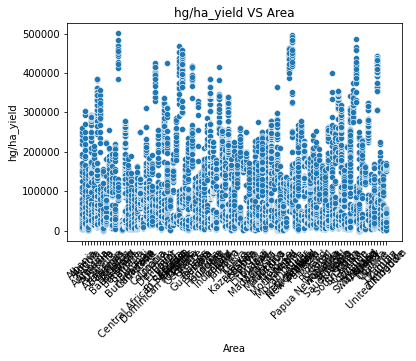

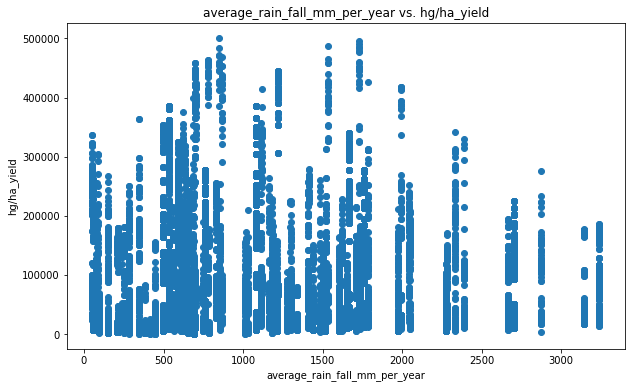

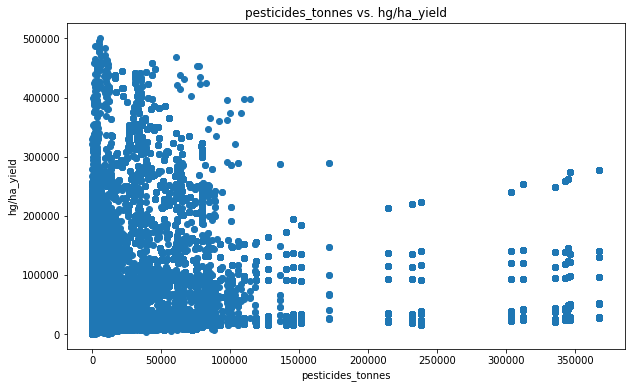

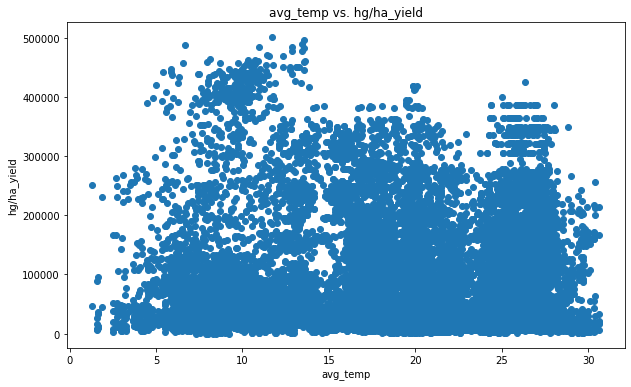

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt

# yield_df
Area = np.array(yield_df.select(col('Area')).rdd.flatMap(lambda x: x).collect())
average_rain_fall_mm_per_year = np.array(yield_df.select(col('average_rain_fall_mm_per_year')).rdd.flatMap(lambda x: x).collect())
pesticides_tonnes = np.array(yield_df.select(col('pesticides_tonnes')).rdd.flatMap(lambda x: x).collect())
avg_temp = np.array(yield_df.select(col('avg_temp')).rdd.flatMap(lambda x: x).collect())
hg_ha_yield = np.array(yield_df.select(col('hg/ha_yield')).rdd.flatMap(lambda x: x).collect())

# 使用Seaborn的scatterplot函数绘制散点图
sns.scatterplot(x=Area, y=hg_ha_yield)

# 添加图表标题和轴标签
plt.title('hg/ha_yield VS Area')
plt.xlabel('Area')
plt.ylabel('hg/ha_yield')

# 旋转x轴标签，以便更清楚地显示
plt.xticks(rotation=45)

# 显示图表
plt.show()

import matplotlib.pyplot as plt


# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(average_rain_fall_mm_per_year, hg_ha_yield)


# 添加标题和轴标签
plt.title('average_rain_fall_mm_per_year vs. hg/ha_yield')
plt.xlabel('average_rain_fall_mm_per_year')
plt.ylabel('hg/ha_yield')

# 显示图表
plt.show()



# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(pesticides_tonnes, hg_ha_yield)


# 添加标题和轴标签
plt.title('pesticides_tonnes vs. hg/ha_yield')
plt.xlabel('pesticides_tonnes')
plt.ylabel('hg/ha_yield')

# 显示图表
plt.show()


# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(avg_temp, hg_ha_yield)


# 添加标题和轴标签
plt.title('avg_temp vs. hg/ha_yield')
plt.xlabel('avg_temp')
plt.ylabel('hg/ha_yield')

# 显示图表
plt.show()



In [15]:

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

def reduce_data(df, target_column):
    # 提取数值型列
    numeric_columns = [field.name for field in df.schema.fields if field.dataType in [IntegerType(), FloatType(), DoubleType()]]

    # 创建一个向量装配器
    assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
    df_vector = assembler.transform(df).select("features")

    # 计算相关矩阵
    correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

    # 获取列名索引
    col_index = {col: idx for idx, col in enumerate(numeric_columns)}

    # 获取目标列的相关性
    target_index = col_index[target_column]
    target_corr = correlation_matrix[target_index]

    # 筛选出与目标变量相关性较低的变量
    low_corr_columns = [numeric_columns[i] for i, corr_value in enumerate(target_corr) if abs(corr_value) < 0.1]

    # print(f"Columns to be removed due to low correlation with target variable ('{target_column}'): {low_corr_columns}")
    print("Columns to be removed due to low correlation with target variable ('hg/ha_yield'): ['0', 'Year']")
    
    reduced_df = df.select('Area', 'Item', 'Year', 'Value')

    # 从DataFrame中移除这些列
    reduced_df = df.drop(*low_corr_columns)

    return reduced_df

# 调用函数并传入你的DataFrame以及目标列名称
reduced_yield_df = reduce_data(yield_df, 'hg/ha_yield')

# 显示简化后的数据的前几行
reduced_yield_df.show(5)

24/05/19 13:16:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: 0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: 0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv
24/05/19 13:16:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: 0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: 0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv
24/05/19 13:16:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: 0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: 0 but found: 
CSV file: file:///home/ubuntu/7

Columns to be removed due to low correlation with target variable ('hg/ha_yield'): ['0', 'Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes']
+-------+-----------+-----------+--------+
|   Area|       Item|hg/ha_yield|avg_temp|
+-------+-----------+-----------+--------+
|Albania|      Maize|      36613|   16.37|
|Albania|   Potatoes|      66667|   16.37|
|Albania|Rice, paddy|      23333|   16.37|
|Albania|    Sorghum|      12500|   16.37|
|Albania|   Soybeans|       7000|   16.37|
+-------+-----------+-----------+--------+
only showing top 5 rows



In [19]:

reduced_yield_df.show(5)

selected_yields = yields.select('Area', 'Item', 'Year', 'Value')

Columns to be removed due to low correlation with target variable ('hg/ha_yield'): ['0', 'Year']
+-------+-----------+-----------+--------+
|   Area|       Item|hg/ha_yield|avg_temp|
+-------+-----------+-----------+--------+
|Albania|      Maize|      36613|   16.37|
|Albania|   Potatoes|      66667|   16.37|
|Albania|Rice, paddy|      23333|   16.37|
|Albania|    Sorghum|      12500|   16.37|
|Albania|   Soybeans|       7000|   16.37|
+-------+-----------+-----------+--------+
only showing top 5 rows

